WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
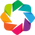

In [2]:
import time
import torch
import math

from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath, GeodesicProbPath
from flow_matching.solver import Solver, ODESolver, RiemannianODESolver
from flow_matching.utils import ModelWrapper
import math
import torch
from torch.utils.data import Dataset, DataLoader

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm
import tqdm

# To avoide meshgrid warning
import warnings

# TOMEK
import math
import pandas as pd
import numpy as np
import arviz as az
import tqdm
import pickle

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

from sbmfi.inference.manifolds import BallManifold, Manifold, PoincareBallManifold
from sbmfi.models.small_models import spiro
from sbmfi.core.coordinater import FluxCoordinateMapper
from sbmfi.inference.complotting import MCMC_PLOT
from sbmfi.core.linalg import LinAlg

import holoviews as hv
from holoviews import dim, opts
hv.extension('bokeh')

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.set_default_dtype(torch.float)
torch.manual_seed(42)


Using gpu


In [4]:
flux_model, kwargs = spiro(backend='torch', seed=0, device='cpu')
fcm = FluxCoordinateMapper(flux_model, kernel_id='rref')
psm = fcm.sampler

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-27


In [48]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)


In [6]:
unif_file = 'unif_polytope_100k_samples.nc'
unif_data = az.from_netcdf(unif_file)
unif_rounded = torch.as_tensor(
    az.extract(unif_data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, device=device, dtype=torch.float
).T

mog_file = 'mog_polytope_100k_samples.nc'
mog_data = az.from_netcdf(mog_file)
mog_rounded = torch.as_tensor(
    az.extract(mog_data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, device=device, dtype=torch.float
).T


In [8]:
torch_linalg = LinAlg(backend='torch', device=device, dtype=np.float32)
def sample_ball(shape):
    return torch_linalg.sample_unit_hyper_sphere_ball(shape, ball=True)

### affine flow

In [9]:
class RandomPairDataset(Dataset):
    def __init__(self, data1: torch.Tensor, data2: torch.Tensor):
        """
        Args:
            data1 (torch.Tensor): First tensor (e.g., features).
            data2 (torch.Tensor): Second tensor (e.g., labels or another modality).
                                    Both tensors must have the same number of samples and be on the same device.
        """
        assert data1.size(0) == data2.size(0), "Both tensors must have the same number of samples"
        assert data1.device == data2.device, "Both tensors must be on the same device"

        self.data1 = data1
        self.data2 = data2
        self.num_samples = data1.size(0)
        self.device = data1.device  # Use the device of the input tensors
        self._shuffle_indices()  # Initial shuffling

    def _shuffle_indices(self):
        # Generate two independent random orderings of indices on the same device as the data.
        self.idx1 = torch.randperm(self.num_samples, device=self.device)
        self.idx2 = torch.randperm(self.num_samples, device=self.device)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        # Retrieve the sample indices using the pre-shuffled index tensors.
        # .item() converts the 0-dim tensor to a Python integer.
        i1 = self.idx1[index].item()
        i2 = self.idx2[index].item()
        sample1 = self.data1[i1]
        sample2 = self.data2[i2]
        return sample1, sample2

    def on_epoch_end(self):
        # Re-shuffle the indices to yield a new pairing for the next epoch.
        self._shuffle_indices()


In [10]:
# training arguments
lr = 0.0001
n_epochs = 50
batch_size = 4096
iterations = 20001
print_every = 2000 
hidden_dim = 1024

# velocity field model init
model = MLP(input_dim=mog_rounded.shape[-1], time_dim=1, hidden_dim=hidden_dim).to(device) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
scheduler = None

dataset = RandomPairDataset(unif_rounded, mog_rounded)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
losses = []

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3) 

In [43]:
def train_main(
    dataloader,
    model, 
    path, 
    optimizer, 
    losses, 
    n_epoch=50, 
    scheduler=None,
):
    n_steps = n_epoch * len(dataloader)
    pbar = tqdm.tqdm(total=n_steps, ncols=120, position=0)
    try:
        start_time = time.time()
        for epoch in range(n_epochs):
            # use fixed data-set
            for i, (unif_chunk, target_chunk) in enumerate(dataloader): 
                optimizer.zero_grad() 
    
                t = torch.rand(unif_chunk.shape[0]).to(device) 
                
                # sample probability path
                path_sample = path.sample(t=t, x_0=unif_chunk, x_1=target_chunk)
            
                # flow matching l2 loss
                loss = torch.pow( model(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
            
                # # optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                else:
                    raise ValueError(f'loss: {loss}')

                loss_float = loss.item()
                losses.append(loss_float)
                pbar.update()
                pbar.set_postfix(loss=round(loss_float, 4))
            if (scheduler is not None):
                scheduler.step()            
    except KeyboardInterrupt:
        pass
    except Exception as e:
        raise e
    finally:
        pbar.close()

train_main(dataloader, model, path, optimizer, losses, n_epoch=50, scheduler=scheduler)

NameError: name 'dataloader' is not defined

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
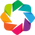

:Scatter   [x]   (y)

In [138]:
hv.Scatter(losses)

In [69]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(model)

In [141]:
step_size = torch.Tensor([0.05]).to(device=device, dtype=torch.float)

x_init = unif_rounded[:20000]
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sal = solver.sample(time_grid=torch.Tensor([0.0, 1.0]).to(dtype=torch.float, device=device), x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
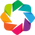

In [142]:
sol = sal[[1]] if len(sal.shape) == 3 else sal[None, ...]
flow_data = az.from_dict(
    posterior={
        'theta': sol.to('cpu').numpy()  # chains x draws x param
    },
    dims={'theta': ['theta_id']},
    coords={'theta_id': psm.rounded_id},
)
flow_plotter = MCMC_PLOT(fcm, flow_data)

In [ ]:
flow_numpy = az.extract(flow_data, combined=True, var_names='theta', keep_dataset=False, rng=2).values.astype(np.double)
in_pol = ((psm._F_round.A.values @ flow_numpy) < psm._F_round.b.values[:, None]).all(0)

in_pol.sum()

In [30]:
means_df = pd.DataFrame(np.hstack([mog_data.attrs['mog_means'], mog_data.attrs['mog_weights'][:, None]]), columns=fcm.theta_id().append(pd.Index(['weights'])))
means_df['weights'] = means_df['weights'].astype(str)
means_df

,R_v7,R_f_out,R_h_out,R_bm,weights
0,0.000000,0.0,0.974004,0.000000,0.25
1,-0.974004,-0.0,-0.000000,-0.000000,0.25
2,0.000000,0.0,0.000000,0.974004,0.5


In [144]:
theta1 = 'R_h_out'
theta2 = 'R_bm'

flow_dens = flow_plotter.grand_theta_plot(theta1, theta2)
flow_points = hv.Points(means_df, kdims=[theta1, theta2], vdims=['weights']).opts(size=5, color='weights', cmap='Dark2')

(flow_dens * flow_points).opts(
    opts.Bivariate(bandwidth=0.1)
).opts(legend_position='bottom')

:Overlay
   .Area.Polytope                   :Area   [R_h_out]   (R_bm)
   .Curve.Polytope                  :Curve   [R_h_out]   (R_bm)
   .Area.Posterior_sampled_support  :Area   [R_h_out]   (R_bm)
   .Curve.Posterior_sampled_support :Curve   [R_h_out]   (R_bm)
   .Bivariate.Density               :Bivariate   [R_h_out,R_bm]   (Density)
   .Points.I                        :Points   [R_h_out,R_bm]   (weights)

### Riemannian

In [49]:
class ProjectToTangent(nn.Module):
    """Projects a vector field onto the tangent plane at the input."""

    def __init__(self, vecfield: nn.Module, manifold: Manifold):
        super().__init__()
        self.vecfield = vecfield
        self.manifold = manifold

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        x = self.manifold.projx(x)
        v = self.vecfield(x, t)
        v = self.manifold.proju(x, v)
        return v

In [78]:
hv.Bivariate(mog_ball.numpy()[:5000, [2,3]]).opts(bandwidth=0.1)

:Bivariate   [x,y]   (Density)

In [167]:
EPS = 1e-5

mog_rounded_2 = torch.as_tensor(
    az.extract(mog_data, combined=True, var_names='theta', keep_dataset=False, rng=2).values
).T
mog_ball = fcm.map_rounded_2_ball(mog_rounded_2)
mog_ball = mog_ball[..., :-1] * (mog_ball[..., [-1]])


In [168]:
class PoincareBallManifold(nn.Module):
    """
    Implements operations on the n-dimensional Poincaré ball model
    of hyperbolic space with negative curvature -c.

    Attributes:
        c (float): positive curvature parameter (default: 1.0).
        eps (float): small epsilon for numerical stability.
    """

    def __init__(self, c: float = 1.0, eps: float = 1e-5):
        super().__init__()
        # Curvature c > 0 => negative curvature -c in the Poincaré model
        self.c = c
        self.eps = eps

    ########################################################
    #  Utility Functions
    ########################################################
    def _norm(self, x: Tensor, keepdim: bool = True) -> Tensor:
        """Compute Euclidean norm of x along last dimension."""
        return torch.norm(x, p=2, dim=-1, keepdim=keepdim).clamp_min(self.eps)

    def _lambda_x(self, x: Tensor) -> Tensor:
        r"""
        Compute the conformal factor:
            λ_x^c = 2 / (1 - c * ||x||^2).
        Used in exponential/logarithmic maps.
        """
        x2 = torch.sum(x * x, dim=-1, keepdim=True).clamp_min(self.eps)
        return 2.0 / (1.0 - self.c * x2).clamp_min(self.eps)

    def _mobius_add(self, x: Tensor, y: Tensor) -> Tensor:
        r"""
        Möbius addition in the Poincaré ball (with curvature c):

        x ⊕_c y =
          ( (1 + 2c <x,y> + c||y||^2) x + (1 - c||x||^2) y )
          ------------------------------------------------
                       (1 + 2c <x,y> + c^2 ||x||^2 ||y||^2)
        """
        xy = torch.sum(x * y, dim=-1, keepdim=True)  # <x,y>
        x2 = torch.sum(x * x, dim=-1, keepdim=True)  # ||x||^2
        y2 = torch.sum(y * y, dim=-1, keepdim=True)  # ||y||^2

        num = (1.0 + 2.0 * self.c * xy + self.c * y2) * x + (1.0 - self.c * x2) * y
        denom = 1.0 + 2.0 * self.c * xy + (self.c ** 2) * x2 * y2
        return num / denom.clamp_min(self.eps)

    def _mobius_neg(self, x: Tensor) -> Tensor:
        """Möbius 'negative' just the usual -x in R^n, used in logmap."""
        return -x

    ########################################################
    #  Required Methods
    ########################################################
    def expmap(self, x: Tensor, u: Tensor) -> Tensor:
        r"""
        Exponential map at point x applied to tangent vector u.

        Formula (c > 0):
            exp_x^c(u) = x ⊕_c(
                tanh( sqrt(c)/2 * λ_x^c * ||u|| ) * (u / ( sqrt(c)*||u|| ))
            )

        where λ_x^c = 2 / (1 - c ||x||^2).

        Args:
            x (Tensor): BxN manifold points (on Poincaré ball).
            u (Tensor): BxN tangent vectors at x.

        Returns:
            Tensor: BxN points in the Poincaré ball.
        """
        norm_u = self._norm(u)  # ||u||
        lambda_x = self._lambda_x(x)  # λ_x^c

        # scale = tanh( sqrt(c)/2 * λ_x^c * ||u|| )
        scaled_factor = torch.tanh(
            torch.sqrt(torch.tensor(self.c, device=x.device)) * lambda_x * norm_u / 2.0
        )

        # direction = u / (||u|| * sqrt(c))
        direction = u / norm_u / torch.sqrt(torch.tensor(self.c, device=x.device))

        gamma = scaled_factor * direction  # same shape as x, y
        return self._mobius_add(x, gamma)

    def logmap(self, x: Tensor, y: Tensor) -> Tensor:
        r"""
        Logarithmic map at x of point y on the ball.

        Formula (c > 0):
            log_x^c(y) =
                2 / ( sqrt(c) * λ_x^c ) * artanh( sqrt(c) * ||-x ⊕_c y|| )
                * ( (-x ⊕_c y) / ||-x ⊕_c y|| )

        Args:
            x (Tensor): BxN manifold points (on Poincaré ball).
            y (Tensor): BxN manifold points (on Poincaré ball).

        Returns:
            Tensor: BxN tangent vectors at x.
        """
        # Möbius subtract is mobius_add(x, -y) or the other way around.
        # But for log, we compute z = (-x) ⊕_c y
        z = self._mobius_add(self._mobius_neg(x), y)
        norm_z = self._norm(z)

        lambda_x = self._lambda_x(x)  # λ_x^c

        # factor = 2/( sqrt(c)*λ_x^c ) * artanh( sqrt(c)*||z|| )
        # direction = z / ||z||
        scale = (
                        2.0
                        / (
                                torch.sqrt(torch.tensor(self.c, device=x.device)) * lambda_x
                        ).clamp_min(self.eps)
                ) * torch.atanh(
            torch.sqrt(torch.tensor(self.c, device=x.device)) * norm_z.clamp_max(1 - self.eps)
        ).clamp_min(self.eps)

        direction = z / norm_z
        return scale * direction

    # def projx(self, x: Tensor) -> Tensor:
    #     """
    #     Project points x onto the open Poincaré ball of radius 1/sqrt(c).
    #     By default, we ensure the norm < 1/sqrt(c).
    #     """
    #     # Radius = 1 / sqrt(c)
    #     maxnorm = 1.0 / math.sqrt(self.c)
    #     norm_x = torch.norm(x, p=2, dim=-1, keepdim=True)
    #     cond = norm_x > maxnorm
    #     # Scale points that are outside the ball
    #     safe_x = x.clone()
    #     safe_x[cond] = (
    #                            safe_x[cond] / norm_x[cond]
    #                    ) * (maxnorm - self.eps)
    #     return safe_x

    def projx(self, x: Tensor) -> Tensor:
        """
        Project points x onto the open Poincaré ball of radius 1/sqrt(c).
        By default, we ensure the norm < 1/sqrt(c).
        """
        maxnorm = 1.0 / math.sqrt(self.c)
        norm_x = torch.norm(x, p=2, dim=-1, keepdim=True)
        # cond has shape [B, 1]. We want [B] for row-wise indexing in x.
        cond = (norm_x > maxnorm).squeeze(-1)  # shape [B]

        safe_x = x.clone()
        # safe_x[cond] has shape [num_cond_true, N]
        # norm_x[cond] has shape [num_cond_true, 1]
        # which will broadcast to [num_cond_true, N]
        safe_x[cond] = (
                               safe_x[cond] / norm_x[cond]
                       ) * (maxnorm - self.eps)
        return safe_x

    def proju(self, x: Tensor, u: Tensor) -> Tensor:
        """
        Project a tangent vector u onto the tangent space at x.
        For the Poincaré disk, the tangent space at x is isomorphic to R^n,
        so we usually do not need a special projection (identity).
        """
        # Typically identity for Poincaré ball, but
        # you could also multiply by the conformal factor if needed for
        # certain gradient adjustments. For now, do identity.
        return u


In [169]:
# training arguments
lr = 1e-3
weight_decay=0.0

n_epochs = 50
batch_size = 4096
iterations = 20001
print_every = 2000 
hidden_dim = 1024


class ProjectToTangent(nn.Module):
    """Projects a vector field onto the tangent plane at the input."""

    def __init__(self, vecfield: nn.Module, manifold: Manifold):
        super().__init__()
        self.vecfield = vecfield
        self.manifold = manifold

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        x = self.manifold.projx(x)
        v = self.vecfield(x, t)
        v = self.manifold.proju(x, v)
        return v

manifold = BallManifold(dim=mog_rounded.shape[-1])
# manifold = PoincareBallManifold(eps=EPS)

# velocity field model init
model = ProjectToTangent(  # Ensures we can just use Euclidean divergence.
    MLP(  # Vector field in the ambient space.
        input_dim=mog_rounded.shape[-1],
        hidden_dim=hidden_dim,
    ),
    manifold=manifold,
).to(device)

# instantiate an affine path object
path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

# init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 

scheduler = None

dataset = torch.utils.data.TensorDataset(mog_ball.to(device=device, dtype=torch.float))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
losses = []

In [170]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3) 

In [171]:
def train_main(
    dataloader,
    model, 
    path, 
    optimizer, 
    losses, 
    n_epoch=50, 
    scheduler=None,
):
    n_steps = n_epoch * len(dataloader)
    pbar = tqdm.tqdm(total=n_steps, ncols=120, position=0)
    try:
        start_time = time.time()
        for epoch in range(n_epochs):
            # use fixed data-set
            for i, chunk in enumerate(dataloader): 
                optimizer.zero_grad() 
                target_chunk = chunk[0]
                prior_chunk = sample_ball(target_chunk.shape)
    
                t = torch.rand(prior_chunk.shape[0]).to(device) 
                
                # sample probability path
                path_sample = path.sample(t=t, x_0=prior_chunk, x_1=target_chunk)
            
                # flow matching l2 loss
                loss = torch.pow( model(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
            
                # # optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                else:
                    raise ValueError(f'loss: {loss}')

                loss_float = loss.item()
                losses.append(loss_float)
                pbar.update()
                pbar.set_postfix(loss=round(loss_float, 4))
                
            if (scheduler is not None):
                scheduler.step()            
    except KeyboardInterrupt:
        pass
    except Exception as e:
        raise e
    finally:
        pbar.close()

train_main(dataloader, model, path, optimizer, losses, n_epoch=50, scheduler=scheduler)

 30%|████████████████████▌                                               | 377/1250 [02:30<05:48,  2.51it/s, loss=0.115]


In [137]:
# step_size = torch.Tensor([0.05]).to(device=device, dtype=torch.float)

# x_init = unif_rounded[:20000]
# solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
# sal = solver.sample(time_grid=torch.Tensor([0.0, 1.0]).to(dtype=torch.float, device=device), x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

In [172]:
hv.Scatter(losses)

:Scatter   [x]   (y)

In [173]:
x_init = sample_ball((10000, mog_ball.shape[-1]))

In [174]:
# step size for ode solver
step_size = 0.01
N = 2

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0, 1, N)  # sample times
T = T.to(device=device)


class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)


x_init = sample_ball((5000, mog_ball.shape[-1]))
wrapped_vf = WrappedModel(model)

solver = RiemannianODESolver(velocity_model=wrapped_vf, manifold=manifold)  # create an ODESolver class
sol = solver.sample(
    x_init=x_init,
    step_size=step_size,
    method="midpoint",
    return_intermediates=True,
    time_grid=T,
    verbose=True,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.87it/s]


In [176]:
means_df = pd.DataFrame(np.hstack([mog_data.attrs['mog_means'], mog_data.attrs['mog_weights'][:, None]]), columns=fcm.theta_id().append(pd.Index(['weights'])))
means_df['weights'] = means_df['weights'].astype(str)
means_df

,R_v7,R_f_out,R_h_out,R_bm,weights
0,0.000000,0.0,0.974004,0.000000,0.25
1,-0.974004,-0.0,-0.000000,-0.000000,0.25
2,0.000000,0.0,0.000000,0.974004,0.5


In [177]:
radius = torch.norm(sol, 2, dim=2, keepdim=True)
ball = sol / radius
ball = torch.cat([ball, radius], dim=-1).to(device='cpu', dtype=torch.double)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
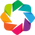

In [178]:
rounded = fcm.map_ball_2_rounded(ball)

rounded = rounded[[1]] if len(rounded.shape) == 3 else rounded[None, ...]
flow_data = az.from_dict(
    posterior={
        'theta': rounded.to('cpu').numpy()  # chains x draws x param
    },
    dims={'theta': ['theta_id']},
    coords={'theta_id': psm.rounded_id},
)
flow_plotter = MCMC_PLOT(fcm, flow_data)

In [179]:
flow_numpy = az.extract(flow_data, combined=True, var_names='theta', keep_dataset=False, rng=2).values.astype(np.double)
in_pol = ((psm._F_round.A.values @ flow_numpy) < psm._F_round.b.values[:, None]).all(0)

in_pol.sum()

5000

In [180]:
theta1 = 'R_h_out'
theta2 = 'R_bm'

flow_dens = flow_plotter.grand_theta_plot(theta1, theta2)
flow_points = hv.Points(means_df, kdims=[theta1, theta2], vdims=['weights']).opts(size=5, color='weights', cmap='Dark2')

(flow_dens * flow_points).opts(
    opts.Bivariate(bandwidth=0.1)
).opts(legend_position='bottom')

:Overlay
   .Area.Polytope                   :Area   [R_h_out]   (R_bm)
   .Curve.Polytope                  :Curve   [R_h_out]   (R_bm)
   .Area.Posterior_sampled_support  :Area   [R_h_out]   (R_bm)
   .Curve.Posterior_sampled_support :Curve   [R_h_out]   (R_bm)
   .Bivariate.Density               :Bivariate   [R_h_out,R_bm]   (Density)
   .Points.I                        :Points   [R_h_out,R_bm]   (weights)

In [129]:
samples = sample_ball((400,4))

samples

tensor([[-0.3275,  0.0314,  0.1497, -0.5622],
        [ 0.1827, -0.3151,  0.2920, -0.7001],
        [ 0.1347,  0.0649,  0.5041,  0.5565],
        ...,
        [ 0.0285,  0.0211,  0.0269, -0.6417],
        [ 0.4539, -0.0598, -0.3317, -0.7539],
        [ 0.2599,  0.2473,  0.4298,  0.3364]], device='cuda:0')